# Data manipulation in Julia

In this session, we will cover the basics of data manipulation in Julia, including
- reading
- merging/joining
- summarizing/grouping
- plotting

At the end of the class, you should be able to construct these plots:

<table>
<tr>
<td> <img src="figures/n_loglik_val_A.pdf" style="width: 350px;"/></td>
<td> <img src="figures/n_loglik_val_F.pdf" style="width: 350px;"/></td>
</tr></table>

We study the sparse inverse covariance problem and compare 3 methods: 
- Meinshausena and Buhlmann's approximation (BM)
- Graphical Lasso (Glasso)
- Discrete formulation (Big-M)

We design experiments with 
- fixed dimension $p=200$
- fixed underlying true sparsity $k_{true}=199$
- varying number of samples $n$ (12 different values)

We run each experiment $10$ times and want to report average results over all simulations. 

## Step 1: Read the data

We generate one CSV file per method (3) per experiment (12) and per simulation (10) !

Let us look at the first CSV file

In [1]:
using DataFrames, CSV

In [ ]:
?CSV.read

In [2]:
df = CSV.read("experiment/baseline_BM_0.csv")

8×17 DataFrame. Omitted printing of 10 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │

In [3]:
size(df)

(8, 17)

Let us have a look at the columns

In [4]:
names(df)

17-element Array{Symbol,1}:
 :run           
 :p             
 :n             
 :ktrue         
 :lambda        
 :k             
 :time          
 :objval        
 :EBIC          
 :loglik_val    
 :loglik_test   
 :TF            
 :FF            
 :operatorNorm  
 :frobeniusNorm 
 :L1MatrixNorm  
 :LInfVectorNorm

The first 4 columns identify the experiment and the simulation
 - :run is the number of the simulation (between 0 and 9)          
 - :p is the dimension of the problem             
 - :n is the number of samples            
 - :ktrue is the true sparsity pattern 

They take the same value for all rows in the file.

The other columns correspond to the regularization path:
 - :lambda is the value of the regularization paramter       
 - :k is the sparsity of the corresponding estimator      
 - :time is the time needed to compute the solution       
 - :objval is the in-sample objective value

Then, we report performance metrics that can be used for cross-validation:
 - :EBIC is the value of the in-sample Extended Bayesian Information Criterion (the lower the better)
 - :loglik_val is the value of the negative log-likelihood on the validation set (the lower the better)

Finally, we report final metrics on the test set
 - :loglik_test is the negative log-likelihood on the test test
 - :TF is the number of true features selected          
 - :FF is the number of false features selected          

We will not use the final 4 columns

**Side note:** Renaming columns

In [5]:
DataFrames.rename(df, (:operatorNorm => :uselessColumn))

8×17 DataFrame. Omitted printing of 10 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │

But did not change the original table df

In [6]:
df

8×17 DataFrame. Omitted printing of 10 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │

Suffix "!" denotes functions which modify their argument (convention only)

In [7]:
DataFrames.rename!(df, (:operatorNorm => :uselessColumn))
df

8×17 DataFrame. Omitted printing of 10 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │

>**\[Exercise\]**: Read/Concatenate 

> There are 120 files for the method "BM", write a Julia function which reads and concatenates all the CSV files into one dataframe

> Note: you can concatenate dataframes horizontally (preserves the first dimension) or vertically (preserves the second dimension) using hcat(df1, df2) or vcat(df1, df2) respectively

In [13]:
vcat(df,df)

16×17 DataFrame. Omitted printing of 10 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │
│ 9   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 10  │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 11  │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 12  │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 13  │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 14  │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 15  │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 16  │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │

In [14]:
function merge_files(prefix)
    i=0
    df = CSV.read(string(prefix, i, ".csv"))
    for i in 1:119
        aux = CSV.read(string(prefix, i, ".csv"))
        df = vcat(df,aux)
    end
    return df
end

merge_files (generic function with 1 method)

In [15]:
bm = merge_files("experiment/baseline_BM_")

960×17 DataFrame. Omitted printing of 10 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │
│ 9   │ 1      │ 200    │ 50     │ 199    │ 0.585938 │ 50     │ 0.382404 │
│ 10  │ 1      │ 200    │ 50     │ 199    │ 0.479134 │ 100    │ 0.732132 │
⋮
│ 950 │ 8      │ 200    │ 600    │ 199    │ 0.113281 │ 298    │ 0.875144 │
│ 951 │ 8      │ 200    │ 600    │ 199    │ 0.107361 │ 348    │ 1.00093  │
│ 952 │ 8      │ 200    │ 600    │ 199    │ 0.102661 │ 398    │ 1.0889   │
│ 953 │ 9      │ 200    │ 600    │ 199    │ 0.578125 │ 50     │ 0.350095 │
│ 954 │ 9      │ 200    │ 600    │ 199    │ 0.494141 │ 100    │ 0.358957 │
│ 955 │ 9      │ 200    │ 600    │ 199    │ 0.429688 │ 149    │ 0.440038 │
│ 956 │ 9      │ 200    │ 600    │ 199    │ 0.203125 │ 199    │ 0.666289 │
│ 957 │ 9      │ 200    │ 600    │ 199    │ 0.120605 │ 249    │ 1.14752  │
│ 958 │ 9      │ 200    │ 600    │ 199    │ 0.111389 │ 298    │ 1.35116  │
│ 959 │ 9      │ 200    │ 600    │ 199    │ 0.10437  │ 348    │ 1.22297  │
│ 960 │ 9      │ 200    │ 600    │ 199    │ 0.100647 │ 398    │ 1.34512  │

## Step 2: Define relevant columns

In the end, we want to represent accuracy ($A$) and false detection rate ($F$) as a funtion of $n/p$

>**\[Exercise\]**: Add columns

> Write a Julia function which takes a dataframe and add three columns: n/p, A and F.

> Note:
$$ A = \dfrac{TF - p}{2 k_{true}}, \quad F = \dfrac{FF}{2 k} $$

In [17]:
bm[:TF]

960-element Array{Union{Missing, Float64},1}:
 296.0
 384.0
 456.0
 490.0
 512.0
 526.0
 536.0
 542.0
 292.0
 368.0
 426.0
 456.0
 474.0
   ⋮  
 598.0
 598.0
 598.0
 598.0
 300.0
 400.0
 498.0
 594.0
 598.0
 598.0
 598.0
 598.0

In [45]:
function add_columns!(df)
    df[:ntop] = ( df[:n] ) ./ (df[:p])
    df[:A] = ( df[:TF] .- df[:p] ) ./ (2 * df[:ktrue])
    df[:F] = ( df[:FF] ) ./ (2 * df[:k])
end

add_columns! (generic function with 1 method)

In [24]:
add_columns!(bm)
bm

960×19 DataFrame. Omitted printing of 12 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │
│ 9   │ 1      │ 200    │ 50     │ 199    │ 0.585938 │ 50     │ 0.382404 │
│ 10  │ 1      │ 200    │ 50     │ 199    │ 0.479134 │ 100    │ 0.732132 │
⋮
│ 950 │ 8      │ 200    │ 600    │ 199    │ 0.113281 │ 298    │ 0.875144 │
│ 951 │ 8      │ 200    │ 600    │ 199    │ 0.107361 │ 348    │ 1.00093  │
│ 952 │ 8      │ 200    │ 600    │ 199    │ 0.102661 │ 398    │ 1.0889   │
│ 953 │ 9      │ 200    │ 600    │ 199    │ 0.578125 │ 50     │ 0.350095 │
│ 954 │ 9      │ 200    │ 600    │ 199    │ 0.494141 │ 100    │ 0.358957 │
│ 955 │ 9      │ 200    │ 600    │ 199    │ 0.429688 │ 149    │ 0.440038 │
│ 956 │ 9      │ 200    │ 600    │ 199    │ 0.203125 │ 199    │ 0.666289 │
│ 957 │ 9      │ 200    │ 600    │ 199    │ 0.120605 │ 249    │ 1.14752  │
│ 958 │ 9      │ 200    │ 600    │ 199    │ 0.111389 │ 298    │ 1.35116  │
│ 959 │ 9      │ 200    │ 600    │ 199    │ 0.10437  │ 348    │ 1.22297  │
│ 960 │ 9      │ 200    │ 600    │ 199    │ 0.100647 │ 398    │ 1.34512  │

## Step 3: Perform the CV

For each experiment and simulation, we need to select the regularization parameter which minimizes the cross-validation criterion (either :EBIC or :loglik_val)

We need to use a "group by" strategy

In [ ]:
?DataFrames.groupby

The command

In [25]:
gr = DataFrames.groupby(bm, [:run, :p, :n, :ktrue])

GroupedDataFrame{DataFrame} with 120 groups based on keys: :run, :p, :n, :ktrue
First Group: 8 rows. Omitted printing of 12 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda   │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰ │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼──────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.650391 │ 50     │ 0.339093 │
│ 2   │ 0      │ 200    │ 50     │ 199    │ 0.541016 │ 100    │ 0.353749 │
│ 3   │ 0      │ 200    │ 50     │ 199    │ 0.460938 │ 149    │ 0.358401 │
│ 4   │ 0      │ 200    │ 50     │ 199    │ 0.422852 │ 199    │ 0.55993  │
│ 5   │ 0      │ 200    │ 50     │ 199    │ 0.385742 │ 249    │ 0.547767 │
│ 6   │ 0      │ 200    │ 50     │ 199    │ 0.36499  │ 298    │ 0.802488 │
│ 7   │ 0      │ 200    │ 50     │ 199    │ 0.347534 │ 348    │ 0.840247 │
│ 8   │ 0      │ 200    │ 50     │ 199    │ 0.329712 │ 398    │ 0.855924 │
⋮
Last Group: 8 rows. Omitted printing of 1

creates a "list of dataframes", corresponding to each group.

In [26]:
length(gr)

120

You can iterate over it

In [27]:
for subgroup in gr
    println(size(subgroup))
end

(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)
(8, 19)


>**\[Exercise\]**: Group by/Concatenate 

> Write a Julia function which takes as arguments
- a dataframe, 
- the list of columns which define an experiment, 
- the column of the cross-validation criterion 

> and performs the cross validation for all experiments.

In [36]:
function perform_cv(df, id_cols, crit_col)
    result = similar(df, 0)
    for subgroup in groupby(df, id_cols)
        i = argmin(subgroup[:,crit_col])
        result = vcat(result, subgroup[i,:])
    end
    return result
    #write your code here
end    

perform_cv (generic function with 1 method)

In [37]:
bm_cv = perform_cv(bm, [:run, :p, :n, :ktrue], :loglik_val)

┌ Warning: Selecting a single row from a `SubDataFrame` will return a `DataFrameRow` in the future. Use `sdf[rowind:rowind, colinds]` to get a `DataFrame`.
│   caller = perform_cv(::DataFrame, ::Array{Symbol,1}, ::Symbol) at In[36]:5
└ @ Main ./In[36]:5


120×19 DataFrame. Omitted printing of 12 columns
│ Row │ run    │ p      │ n      │ ktrue  │ lambda    │ k      │ time     │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64⍰  │ Int64⍰ │ Float64⍰ │
├─────┼────────┼────────┼────────┼────────┼───────────┼────────┼──────────┤
│ 1   │ 0      │ 200    │ 50     │ 199    │ 0.329712  │ 398    │ 0.855924 │
│ 2   │ 1      │ 200    │ 50     │ 199    │ 0.322754  │ 398    │ 0.768193 │
│ 3   │ 2      │ 200    │ 50     │ 199    │ 0.324585  │ 398    │ 0.828302 │
│ 4   │ 3      │ 200    │ 50     │ 199    │ 0.325928  │ 398    │ 0.805412 │
│ 5   │ 4      │ 200    │ 50     │ 199    │ 0.333435  │ 398    │ 0.898663 │
│ 6   │ 5      │ 200    │ 50     │ 199    │ 0.324219  │ 398    │ 0.642827 │
│ 7   │ 6      │ 200    │ 50     │ 199    │ 0.332031  │ 398    │ 0.655028 │
│ 8   │ 7      │ 200    │ 50     │ 199    │ 0.322754  │ 398    │ 0.86623  │
│ 9   │ 8      │ 200    │ 50     │ 199    │ 0.329712  │ 398    │ 0.818161 │
│ 10  │ 9      │ 200    │ 50     │ 199    │ 0.33252   │ 398    │ 0.716426 │
⋮
│ 110 │ 9      │ 200    │ 550    │ 199    │ 0.10495   │ 398    │ 1.29207  │
│ 111 │ 0      │ 200    │ 600    │ 199    │ 0.0996704 │ 398    │ 1.22638  │
│ 112 │ 1      │ 200    │ 600    │ 199    │ 0.100098  │ 398    │ 1.0167   │
│ 113 │ 2      │ 200    │ 600    │ 199    │ 0.103638  │ 398    │ 1.16374  │
│ 114 │ 3      │ 200    │ 600    │ 199    │ 0.10022   │ 398    │ 0.911356 │
│ 115 │ 4      │ 200    │ 600    │ 199    │ 0.101318  │ 398    │ 1.03445  │
│ 116 │ 5      │ 200    │ 600    │ 199    │ 0.103333  │ 398    │ 0.979897 │
│ 117 │ 6      │ 200    │ 600    │ 199    │ 0.101074  │ 398    │ 0.949421 │
│ 118 │ 7      │ 200    │ 600    │ 199    │ 0.0969238 │ 398    │ 1.31701  │
│ 119 │ 8      │ 200    │ 600    │ 199    │ 0.102661  │ 398    │ 1.0889   │
│ 120 │ 9      │ 200    │ 600    │ 199    │ 0.100647  │ 398    │ 1.34512  │

In [38]:
size(bm_cv)

(120, 19)

## Step 4: Aggregate results

For each experiment, we want to compute average accuracy and false detection (and their corresponding standard deviation)

>**\[Exercise\]**: Group by/Concatenate 

> Use a "group by" syntax to write a Julia function which takes as arguments
- a dataframe, 
- the list of columns which define an experiment, 

> and returns a dataframe with average/standard deviation for A.

In [39]:
using Statistics
function aggregate_A(df, exp_cols)
    output = DataFrame(ntop=Float64[], A_mean=[], A_std=[])
    for g in groupby(df, exp_cols)
        push!(output, [mean(g[:n] ./ g[:p]), mean(g[:A]), std(g[:A])])
    end
    return output
end

aggregate_A (generic function with 1 method)

In [40]:
aggregate_A(bm_cv, [:p, :n, :ktrue])

┌ Warning: `sdf[colind]` will create a view of `parent(sdf)[colind]` in the future. Use sdf[:, colind]` to get a freshly allocated vector.
│   caller = aggregate_A(::DataFrame, ::Array{Symbol,1}) at In[39]:5
└ @ Main ./In[39]:5
┌ Warning: `sdf[colind]` will create a view of `parent(sdf)[colind]` in the future. Use sdf[:, colind]` to get a freshly allocated vector.
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: `sdf[colind]` will create a view of `parent(sdf)[colind]` in the future. Use sdf[:, colind]` to get a freshly allocated vector.
│   caller = aggregate_A(::DataFrame, ::Array{Symbol,1}) at In[39]:5
└ @ Main ./In[39]:5
┌ Warning: `sdf[colind]` will create a view of `parent(sdf)[colind]` in the future. Use sdf[:, colind]` to get a freshly allocated vector.
│   caller = aggregate_A(::DataFrame, ::Array{Symbol,1}) at In[39]:5
└ @ Main ./In[39]:5


12×3 DataFrame
│ Row │ ntop    │ A_mean   │ A_std      │
│     │ Float64 │ Any      │ Any        │
├─────┼─────────┼──────────┼────────────┤
│ 1   │ 0.25    │ 0.721106 │ 0.0744688  │
│ 2   │ 0.5     │ 0.936683 │ 0.0450209  │
│ 3   │ 0.75    │ 0.979899 │ 0.0170821  │
│ 4   │ 1.0     │ 0.992462 │ 0.00925072 │
│ 5   │ 1.25    │ 0.996985 │ 0.00423756 │
│ 6   │ 1.5     │ 0.99799  │ 0.0035136  │
│ 7   │ 1.75    │ 0.998492 │ 0.00242737 │
│ 8   │ 2.0     │ 0.998492 │ 0.00242737 │
│ 9   │ 2.25    │ 0.998995 │ 0.00211878 │
│ 10  │ 2.5     │ 0.999497 │ 0.00158908 │
│ 11  │ 2.75    │ 0.999497 │ 0.00158908 │
│ 12  │ 3.0     │ 0.999497 │ 0.00158908 │

This is already the second time we are writing a code like this: iterate over all subgroups, perform some data manipulations and concatenate results from each subgroups. There must be a better way! 

Indeed...

In [ ]:
by(df, cols) do aux #Similar as "for aux in groupby(df, cols)"
    #write all operations you want to do
    #last line should be a dataframe
end

This is refered to as the **split-apply-combine** strategy

>**\[Exercise\]**: "Group by/Concatenate in one shot" 

> Rewrite aggregate_A using a "by(df, col) do ..." syntax

In [ ]:
using Statistics
function aggregate_A2(df, exp_cols)
    by(df, exp_cols) do aux
        DataFrame(ntop=mean(aux[:,:ntop]), 
            A_mean=mean(aux[:,:A]),
            A_std=std(aux[:,:A]))
    end
end

In [ ]:
aggregate_A2(bm_cv, [:p, :n, :ktrue])

NB: Notice that this syntax always adds the columns you grouped on.

Yet, we still had to manually create columns. It can be tedious if you want to look at multiple outputs (A, F, time, loglik_test,...). There must be a better way!

Indeed...

In [ ]:
?DataFrames.aggregate

>**\[Exercise\]**: "Aggregate" 

> Rewrite aggregate_A2 using the aggregate function

In [41]:
using Statistics
function aggregate_A3(df, exp_cols)
    by(df, exp_cols) do aux
        aggregate(aux[[:A, :F, :time]], [mean, std])
    end
end

aggregate_A3 (generic function with 1 method)

In [42]:
aggregate_A3(bm_cv, [:p, :n, :ktrue])

┌ Warning: `sdf[colinds]` will create a `SubDataFrame` in the future. Use `sdf[:, colinds]` to get a `DataFrame`.
│   caller = (::getfield(Main, Symbol("##3#4")))(::SubDataFrame{Array{Int64,1}}) at In[41]:4
└ @ Main ./In[41]:4


12×9 DataFrame. Omitted printing of 3 columns
│ Row │ p      │ n      │ ktrue  │ A_mean   │ F_mean   │ time_mean │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64  │ Float64  │ Float64   │
├─────┼────────┼────────┼────────┼──────────┼──────────┼───────────┤
│ 1   │ 200    │ 50     │ 199    │ 0.721106 │ 0.627638 │ 0.785517  │
│ 2   │ 200    │ 100    │ 199    │ 0.936683 │ 0.516583 │ 0.883515  │
│ 3   │ 200    │ 150    │ 199    │ 0.979899 │ 0.494221 │ 0.931037  │
│ 4   │ 200    │ 200    │ 199    │ 0.992462 │ 0.476382 │ 0.984862  │
│ 5   │ 200    │ 250    │ 199    │ 0.996985 │ 0.466583 │ 0.979372  │
│ 6   │ 200    │ 300    │ 199    │ 0.99799  │ 0.462312 │ 1.02449   │
│ 7   │ 200    │ 350    │ 199    │ 0.998492 │ 0.467337 │ 0.994539  │
│ 8   │ 200    │ 400    │ 199    │ 0.998492 │ 0.457286 │ 1.03669   │
│ 9   │ 200    │ 450    │ 199    │ 0.998995 │ 0.455779 │ 1.06067   │
│ 10  │ 200    │ 500    │ 199    │ 0.999497 │ 0.451759 │ 1.13404   │
│ 11  │ 200    │ 550    │ 199    │ 0.999497 │ 0.455528 │ 1.09722   │
│ 12  │ 200    │ 600    │ 199    │ 0.999497 │ 0.454774 │ 1.1033    │

>**\[Exercise\]**: "Split-apply-combine" strategy 

> Write a Julia function which takes a dataframe and returns summary statistics over all simulations for A, F, time and loglik_test

In [46]:
using Statistics
function aggregate_experiment(df, exp_cols)
    by(df, exp_cols) do aux
        aggregate(aux[:,[:ntop, :A, :F, :time]], :ntop, [mean, std])
    end
end

aggregate_experiment (generic function with 1 method)

In [47]:
aggregate_experiment(bm_cv, [:p, :n, :ktrue])

KeyError: KeyError: key :ntop not found

## Step 5: Upload and process results for all methods

In [48]:
bm = merge_files("experiment/baseline_BM_") #1
add_columns!(bm) #2
bm_cv = perform_cv(bm, [:run, :p, :n, :ktrue], :loglik_val) #3
bm_path = aggregate_experiment(bm_cv, [:p, :n, :ktrue]) #4

glasso = merge_files("experiment/baseline_Glasso_")
add_columns!(glasso)
glasso_cv = perform_cv(glasso, [:run, :p, :n, :ktrue], :loglik_val)
glasso_path = aggregate_experiment(glasso_cv, [:p, :n, :ktrue])

bigm = merge_files("experiment/n_bigm_")
add_columns!(bigm)
bigm_cv = perform_cv(bigm, [:run, :p, :n, :ktrue], :loglik_val)
bigm_path = aggregate_experiment(bigm_cv, [:p, :n, :ktrue])

12×10 DataFrame. Omitted printing of 3 columns
│ Row │ p      │ n      │ ktrue  │ ntop    │ A_mean   │ F_mean     │ time_mean │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64 │ Float64  │ Float64    │ Float64   │
├─────┼────────┼────────┼────────┼─────────┼──────────┼────────────┼───────────┤
│ 1   │ 200    │ 50     │ 199    │ 0.25    │ 0.471357 │ 0.228281   │ 670.304   │
│ 2   │ 200    │ 100    │ 199    │ 0.5     │ 0.831658 │ 0.168342   │ 2534.68   │
│ 3   │ 200    │ 150    │ 199    │ 0.75    │ 0.931658 │ 0.127372   │ 2408.91   │
│ 4   │ 200    │ 200    │ 199    │ 1.0     │ 0.954271 │ 0.0954774  │ 2554.88   │
│ 5   │ 200    │ 250    │ 199    │ 1.25    │ 0.963317 │ 0.0498315  │ 2504.69   │
│ 6   │ 200    │ 300    │ 199    │ 1.5     │ 0.977889 │ 0.0419891  │ 2310.51   │
│ 7   │ 200    │ 350    │ 199    │ 1.75    │ 0.983417 │ 0.0165829  │ 882.744   │
│ 8   │ 200    │ 400    │ 199    │ 2.0     │ 0.988442 │ 0.0315372  │ 928.419   │
│ 9   │ 200    │ 450    │ 199    │ 2.25    │ 0.990955 │ 0.0290246  │ 903.474   │
│ 10  │ 200    │ 500    │ 199    │ 2.5     │ 0.990955 │ 0.00904523 │ 842.546   │
│ 11  │ 200    │ 550    │ 199    │ 2.75    │ 0.99196  │ 0.0080402  │ 824.462   │
│ 12  │ 200    │ 600    │ 199    │ 3.0     │ 0.99397  │ 0.0260096  │ 950.609   │

## Step 6: Plot

Julia has a very nice plot package [**Plots.jl**](https://juliaplots.github.io). Plots.jl is an interface which sits on top of many backends.

In [49]:
using Plots

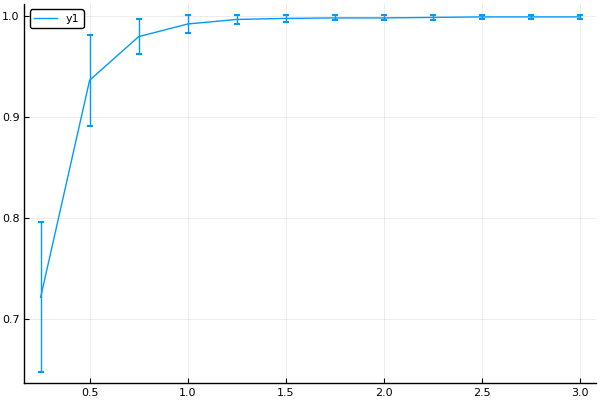

In [50]:
Plots.pyplot() #pyplot backend
Plots.plot(bm_path[:ntop], bm_path[:A_mean], yerr=bm_path[:A_std])

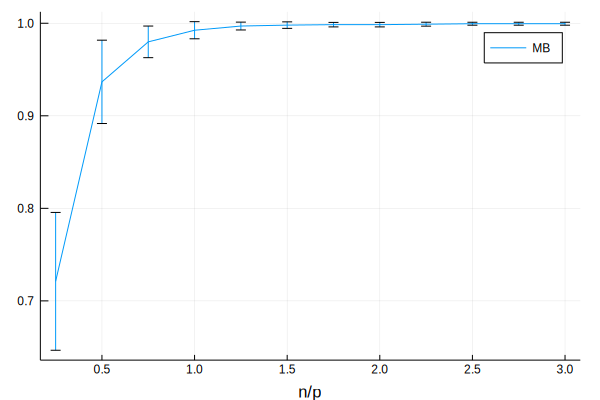

In [51]:
Plots.gr() #GR backend (default)
Plots.plot(bm_path[:ntop], bm_path[:A_mean], yerr=bm_path[:A_std], label="MB", xaxis="n/p")

Use the plot! function to modify the current plot.

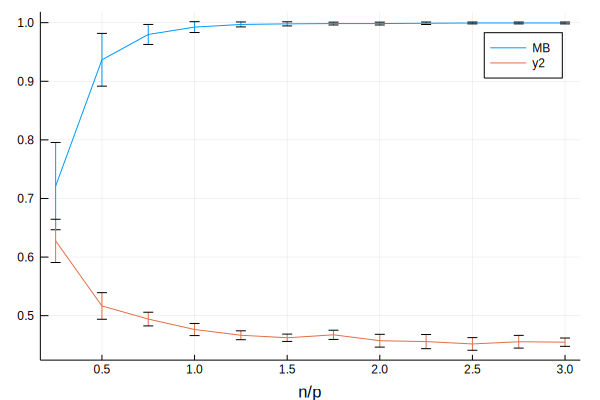

In [52]:
Plots.plot!(bm_path[:ntop], bm_path[:F_mean], yerr=bm_path[:F_std])

>**\[Exercise\]**: Plotting 

> Show on one graph how the accuracy $A$ evolves as $n/p$ increases for all methods

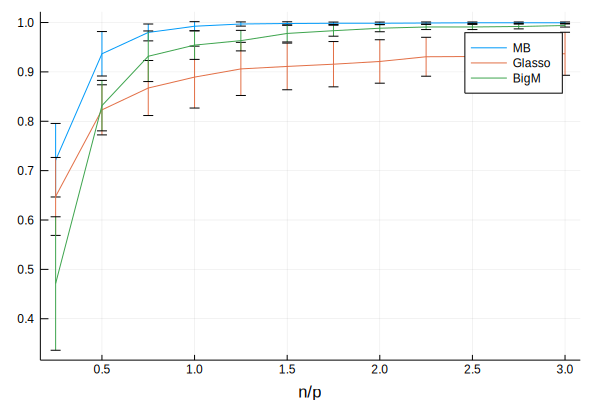

In [54]:
Plots.plot(bm_path[:ntop], bm_path[:A_mean], yerr=bm_path[:A_std], label="MB", xaxis="n/p")
Plots.plot!(glasso_path[:ntop], glasso_path[:A_mean], yerr=glasso_path[:A_std], label="Glasso", xaxis="n/p")
Plots.plot!(bigm_path[:ntop], bigm_path[:A_mean], yerr=bigm_path[:A_std], label="BigM", xaxis="n/p")

**Bonus: ** 

- Other syntax using the StatPlots package: [**StatPlots.jl**](https://github.com/JuliaPlots/StatPlots.jl) implements some useful recipes in data analysis and statistics
- You can use LaTeX text in your legends using [**LaTeXStrings.jl**](https://github.com/stevengj/LaTeXStrings.jl)

In [55]:
using StatPlots, LaTeXStrings

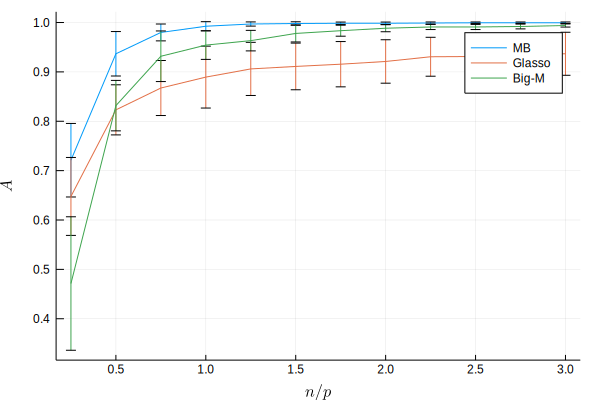

In [56]:
@df bm_path StatPlots.plot(:ntop, :A_mean, yerr=:A_std, label="MB")
@df glasso_path StatPlots.plot!(:ntop, :A_mean, yerr=:A_std, label="Glasso")
@df bigm_path StatPlots.plot!(:ntop, :A_mean, yerr=:A_std, label="Big-M")
xaxis!(L"n/p")
yaxis!(L"A")

It can be tedious to write a line for each method specifically. It would be more efficient to:
- add a column method to each dataframe
- merge the three dataframes into one
- use the method column as a group indicator

In [57]:
bm_path[:method] = "MB"
glasso_path[:method] = "Glasso"
bigm_path[:method] = "Big-M"

"Big-M"

In [58]:
bm_path

12×11 DataFrame. Omitted printing of 4 columns
│ Row │ p      │ n      │ ktrue  │ ntop    │ A_mean   │ F_mean   │ time_mean │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64 │ Float64  │ Float64  │ Float64   │
├─────┼────────┼────────┼────────┼─────────┼──────────┼──────────┼───────────┤
│ 1   │ 200    │ 50     │ 199    │ 0.25    │ 0.721106 │ 0.627638 │ 0.785517  │
│ 2   │ 200    │ 100    │ 199    │ 0.5     │ 0.936683 │ 0.516583 │ 0.883515  │
│ 3   │ 200    │ 150    │ 199    │ 0.75    │ 0.979899 │ 0.494221 │ 0.931037  │
│ 4   │ 200    │ 200    │ 199    │ 1.0     │ 0.992462 │ 0.476382 │ 0.984862  │
│ 5   │ 200    │ 250    │ 199    │ 1.25    │ 0.996985 │ 0.466583 │ 0.979372  │
│ 6   │ 200    │ 300    │ 199    │ 1.5     │ 0.99799  │ 0.462312 │ 1.02449   │
│ 7   │ 200    │ 350    │ 199    │ 1.75    │ 0.998492 │ 0.467337 │ 0.994539  │
│ 8   │ 200    │ 400    │ 199    │ 2.0     │ 0.998492 │ 0.457286 │ 1.03669   │
│ 9   │ 200    │ 450    │ 199    │ 2.25    │ 0.998995 │ 0.455779 │ 1.06067   │
│ 10  │ 200    │ 500    │ 199    │ 2.5     │ 0.999497 │ 0.451759 │ 1.13404   │
│ 11  │ 200    │ 550    │ 199    │ 2.75    │ 0.999497 │ 0.455528 │ 1.09722   │
│ 12  │ 200    │ 600    │ 199    │ 3.0     │ 0.999497 │ 0.454774 │ 1.1033    │

In [60]:
big_df = vcat(bm_path, glasso_path)
big_df = vcat(big_df, bigm_path)

36×11 DataFrame. Omitted printing of 4 columns
│ Row │ p      │ n      │ ktrue  │ ntop    │ A_mean   │ F_mean     │ time_mean │
│     │ Int64⍰ │ Int64⍰ │ Int64⍰ │ Float64 │ Float64  │ Float64    │ Float64   │
├─────┼────────┼────────┼────────┼─────────┼──────────┼────────────┼───────────┤
│ 1   │ 200    │ 50     │ 199    │ 0.25    │ 0.721106 │ 0.627638   │ 0.785517  │
│ 2   │ 200    │ 100    │ 199    │ 0.5     │ 0.936683 │ 0.516583   │ 0.883515  │
│ 3   │ 200    │ 150    │ 199    │ 0.75    │ 0.979899 │ 0.494221   │ 0.931037  │
│ 4   │ 200    │ 200    │ 199    │ 1.0     │ 0.992462 │ 0.476382   │ 0.984862  │
│ 5   │ 200    │ 250    │ 199    │ 1.25    │ 0.996985 │ 0.466583   │ 0.979372  │
│ 6   │ 200    │ 300    │ 199    │ 1.5     │ 0.99799  │ 0.462312   │ 1.02449   │
│ 7   │ 200    │ 350    │ 199    │ 1.75    │ 0.998492 │ 0.467337   │ 0.994539  │
│ 8   │ 200    │ 400    │ 199    │ 2.0     │ 0.998492 │ 0.457286   │ 1.03669   │
│ 9   │ 200    │ 450    │ 199    │ 2.25    │ 0.998995 │ 0.455779   │ 1.06067   │
│ 10  │ 200    │ 500    │ 199    │ 2.5     │ 0.999497 │ 0.451759   │ 1.13404   │
⋮
│ 26  │ 200    │ 100    │ 199    │ 0.5     │ 0.831658 │ 0.168342   │ 2534.68   │
│ 27  │ 200    │ 150    │ 199    │ 0.75    │ 0.931658 │ 0.127372   │ 2408.91   │
│ 28  │ 200    │ 200    │ 199    │ 1.0     │ 0.954271 │ 0.0954774  │ 2554.88   │
│ 29  │ 200    │ 250    │ 199    │ 1.25    │ 0.963317 │ 0.0498315  │ 2504.69   │
│ 30  │ 200    │ 300    │ 199    │ 1.5     │ 0.977889 │ 0.0419891  │ 2310.51   │
│ 31  │ 200    │ 350    │ 199    │ 1.75    │ 0.983417 │ 0.0165829  │ 882.744   │
│ 32  │ 200    │ 400    │ 199    │ 2.0     │ 0.988442 │ 0.0315372  │ 928.419   │
│ 33  │ 200    │ 450    │ 199    │ 2.25    │ 0.990955 │ 0.0290246  │ 903.474   │
│ 34  │ 200    │ 500    │ 199    │ 2.5     │ 0.990955 │ 0.00904523 │ 842.546   │
│ 35  │ 200    │ 550    │ 199    │ 2.75    │ 0.99196  │ 0.0080402  │ 824.462   │
│ 36  │ 200    │ 600    │ 199    │ 3.0     │ 0.99397  │ 0.0260096  │ 950.609   │

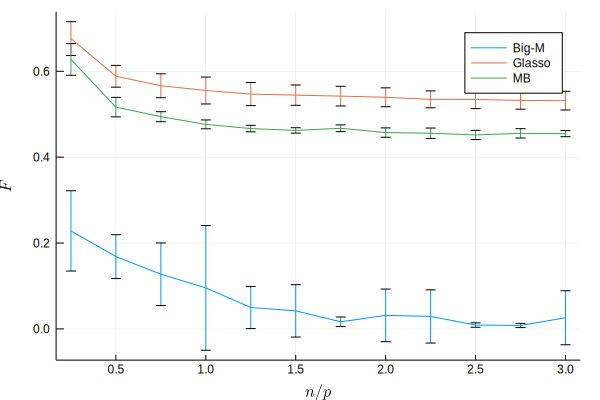

In [61]:
@df big_df StatPlots.plot(:ntop, :F_mean, yerr=:F_std, group=:method, line=1)
xaxis!(L"n/p")
yaxis!(L"F")

## Bonus: Interoperability and RCall

Julia has a growing number of packages implementing basic up to state-of-the-art statistics/ML techniques (e.g. GLM, GLMnet, LibLinear, ...) but is still a young programming language. 

**Good news!** If you ever need to, you can easily interact directly with R or Python

In [62]:
using RCall

You can easily write and compile R code with the Rstring syntaxt

In [63]:
R"1+2"

RObject{RealSxp}
[1] 3


You can use Julia objects in the R code using the "$" prefix

Note: avoid using special characters for variable names

In [64]:
R"$big_df"

RObject{VecSxp}
     p   n ktrue ntop    A_mean      F_mean    time_mean       A_std
1  200  50   199 0.25 0.7211055 0.627638191    0.7855166 0.074468752
2  200 100   199 0.50 0.9366834 0.516582915    0.8835154 0.045020938
3  200 150   199 0.75 0.9798995 0.494221106    0.9310368 0.017082142
4  200 200   199 1.00 0.9924623 0.476381910    0.9848615 0.009250721
5  200 250   199 1.25 0.9969849 0.466582915    0.9793723 0.004237558
6  200 300   199 1.50 0.9979899 0.462311558    1.0244878 0.003513597
7  200 350   199 1.75 0.9984925 0.467336683    0.9945393 0.002427366
8  200 400   199 2.00 0.9984925 0.457286432    1.0366943 0.002427366
9  200 450   199 2.25 0.9989950 0.455778894    1.0606741 0.002118779
10 200 500   199 2.50 0.9994975 0.451758794    1.1340409 0.001589084
11 200 550   199 2.75 0.9994975 0.455527638    1.0972168 0.001589084
12 200 600   199 3.00 0.9994975 0.454773869    1.1032981 0.001589084
13 200  50   199 0.25 0.6477387 0.676130653    1.5010110 0.078938737
14 200 100   199 0

So if you
- do not know how to do something in Julia
- do know how to do it in R 
- are lazy to go from one language into another 

Simply use RCall!

┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /Users/jpauph/.julia/packages/RCall/RPlFw/src/io.jl:110
┌ Warning: RCall.jl: Find out what's changed in ggplot2 at
│ http://github.com/tidyverse/ggplot2/releases.
└ @ RCall /Users/jpauph/.julia/packages/RCall/RPlFw/src/io.jl:110


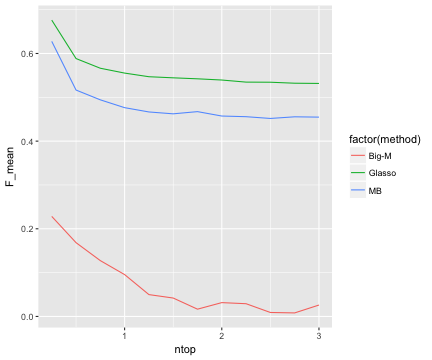

RObject{VecSxp}


In [65]:
R"""
library(dplyr)
library(ggplot2)

$big_df %>% 
    ggplot()+aes(x=ntop, y=F_mean, color=factor(method)) + geom_line()
"""

## Bonus: Saving Julia objects using 

JLD/JLD2 enables to save/load Julia objects very easily (similar to pickle for Python)

In [66]:
using JLD2

In [67]:
@save "test.jld2" big_df

In [68]:
@load "test.jld2" big_df

1-element Array{Symbol,1}:
 :big_df